In [ ]:
from auxiliary_methods import *
from simulation_functions import kang_shafer_data
import numpy as np
import pandas as pd

In [3]:
df = kang_shafer_data(size=10000)
max_k = 30
df.head()

,x1,x2,x3,x4,T,Y
0,1.764052,-0.202117,0.330046,0.371232,0,265.794553
1,0.400157,-0.833231,-0.000480,0.304784,0,214.898689
2,0.978738,1.733600,0.818116,0.504125,1,279.221875
3,2.240893,0.190649,0.428214,0.135300,1,281.118411
4,1.867558,-0.177810,-2.503947,0.653759,0,232.973757


# Baseline evaluations

In [10]:
IPW = calc_inv_propensity_score_weighting(df)
IPW

-28.352557954561235

In [4]:
baseline_euclidean = calc_matching(df, dist_func='euclidean', k=range(1, max_k+1))
baseline_euclidean[0]

-1.3579868981886536

In [5]:
baseline_mahalanobis = calc_matching(df, dist_func='mahalanobis', k=range(1,max_k+1))
baseline_mahalanobis[0]

-1.333173956283655

# Evaluations from treatment predictions

In [7]:
model_t_euclidean = calc_model_t_shap_matching(df, dist_func='euclidean', k=range(1,max_k+1))
model_t_euclidean[0]

0.8777853572189062

In [8]:
model_t_mahalanobis = calc_model_t_shap_matching(df, dist_func='mahalanobis', k=range(1,max_k+1))
model_t_mahalanobis[0]

1.1145609873951707

# Evaluation from outcome predictions

In [9]:
model_y_euclidean = calc_model_y_shap_matching(df, dist_func='euclidean', k=range(1,max_k+1))
model_y_euclidean[0]

-0.593598248071387

In [10]:
model_y_mahalanobis = calc_model_y_shap_matching(df, dist_func='mahalanobis', k=range(1,max_k+1))
model_y_mahalanobis[0]

-1.3287997121288737

# Evaluation from outcome and treatment predictions

In [11]:
model_y_model_t_euclidean = calc_model_y_and_model_t_shap_matching(
    df, combining_method='ratio', dist_func='euclidean', k=range(1,max_k+1))
model_y_model_t_euclidean[0]

-17.782197619595536

In [12]:
model_y_model_t_mahalanobis = calc_model_y_and_model_t_shap_matching(
    df, combining_method='ratio', dist_func='mahalanobis', k=range(1,max_k+1))
model_y_model_t_mahalanobis[0]

-19.290467869280803

# Save all joint values

In [14]:
joint_values = pd.DataFrame({'k':range(1, max_k+1), 
                            'baseline_euclidean':baseline_euclidean, 
                            'baseline_mahalanobis':baseline_mahalanobis, 
                            'model_t_euclidean':model_t_euclidean, 
                            'model_t_mahalanobis':model_t_mahalanobis, 
                            'model_y_euclidean':model_y_euclidean, 
                            'model_y_mahalanobis':model_y_mahalanobis, 
                            'model_y_model_t_euclidean':model_y_model_t_euclidean, 
                            'model_y_model_t_mahalanobis':model_y_model_t_mahalanobis
                           })
joint_values.head()

,k,baseline_euclidean,baseline_mahalanobis,model_t_euclidean,model_t_mahalanobis,model_y_euclidean,model_y_mahalanobis,model_y_model_t_euclidean,model_y_model_t_mahalanobis
0,1,-1.357987,-1.333174,0.877785,1.114561,-0.593598,-1.328800,-17.782198,-19.290468
1,2,-1.623129,-1.598366,0.711033,0.942500,-0.652222,-1.521034,-17.668081,-19.222156
2,3,-1.839419,-1.817080,0.683899,0.838269,-0.696537,-1.721348,-17.830536,-19.098885
3,4,-1.995404,-1.968894,0.546256,0.708775,-0.738726,-1.924029,-17.915762,-19.220932
4,5,-2.107631,-2.068869,0.481273,0.657906,-0.772231,-2.027690,-18.079348,-19.134381


In [15]:
joint_values.to_csv('../Data/kang_schafer_outputs.csv')

In [4]:
joint_values = pd.read_csv('../Data/kang_schafer_outputs.csv', index_col=0)

# Plot the joint values

In [5]:
joint_values.columns[1:]

Index(['baseline_euclidean', 'baseline_mahalanobis', 'model_t_euclidean',
       'model_t_mahalanobis', 'model_y_euclidean', 'model_y_mahalanobis',
       'model_y_model_t_euclidean', 'model_y_model_t_mahalanobis'],
      dtype='object')

In [6]:
long_values = pd.DataFrame(columns=['num_neighbors', 'model_type', 'distance', 'ATT value'])
for model_type in ['baseline', 'model_t', 'model_y', 'model_y_model_t']:
    for distance in ['euclidean', 'mahalanobis']:
        long_values = pd.concat([long_values, 
                                 pd.DataFrame({'num_neighbors':joint_values.k, 
                                               'model_type':model_type, 
                                               'distance':distance, 
                                               'ATT value':joint_values['_'.join([model_type, distance])]})])
long_values.shape

(240, 4)

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

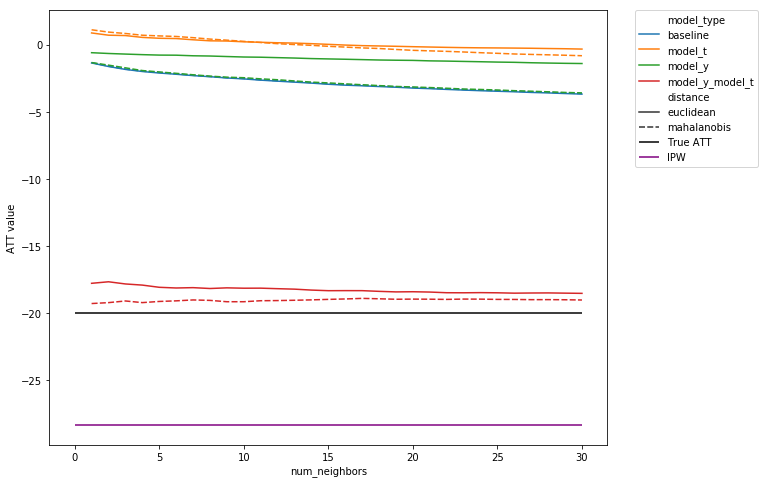

In [14]:
plt.figure(figsize=(10, 8))
ax = sns.lineplot(data=long_values, x='num_neighbors', y='ATT value', hue='model_type', style='distance')
plt.hlines(-20, 0, joint_values.k.max(), label="True ATT")
plt.hlines(IPW, 0, joint_values.k.max(), colors=['purple'], label="IPW")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('../Paper/images/kang_schafer_ATE_estimations_by_neighbor.jpg')
plt.show()